## Introduction
The segmentation in medical images involves the extraction of regions of interest (ROIs) from 3D data. This technique allows to follow the growing of ROIs therefore, adapt the medical treatment of the subject. Until recently, it was the doctors who performed this operation. To make their job easier, AI can be used to perform the segmentation. Own use case will be the segmentation of human glioma from MRI. To perform this, we will use BraTs 2017 database and U-Net architecture. We propose to deploy this solution in the following part.

In [1]:
#Loading the necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import torchio
import pydicom
from tqdm.notebook import tqdm
import nibabel as nib
from nibabel.testing import data_path
import os
from tqdm.notebook import tqdm
import glob
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision 
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F

## Loading images
At first, some words about BraTs 2017 dataset. The BraTs 2017 contains 285 brain tumor MRI scans, with four MRI modalities as T1, T1ce, T2, and Flair. In our use case, we will use only T1_ce and flair. The images were acquired in 19 institutions. So, we need to check some information:
- Shape of each image
- If this is normalized

First, let's display the metadata of the first images:

In [44]:
path = "/home/theo/Documents/Biomedical/AI_biomed/brats2018tpia"

path_each_subject = glob.glob(path + '/*')
path_images_one_subject = glob.glob(path_each_subject[0] + '/*.nii.gz')
path_images_one_subject.sort()

flair = nib.load(path_images_one_subject[0])

In [3]:
#Define fonction to load images

def load_img(path, z_slice):
    
    flair = nib.load(path[0])
    flair = flair.get_fdata()
    flair = flair[:,:,z_slice]
        
    seg = nib.load(path[1])
    seg = seg.get_fdata()
    seg = seg[:,:,z_slice]
    seg = np.where(seg!= 0, 1 ,0)
    seg = np.reshape(seg,(1,240,240))
        
    t1_ce = nib.load(path[2])
    t1_ce = t1_ce.get_fdata()
    t1_ce = t1_ce[:,:,z_slice]
    
    #Return flair,  segmentation and t1_ce modalities
    return(flair, seg, t1_ce)
    

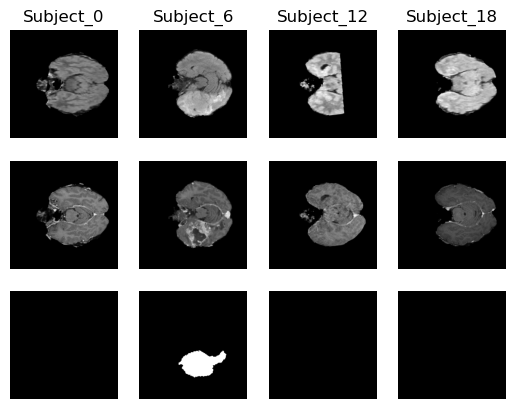

Shape identical for all images :  True


In [4]:
#Please, refer your local path of dataset
path = "/home/theo/Documents/Biomedical/AI_biomed/brats2018tpia"

path_each_subject = glob.glob(path + '/*')
shape_boolean =  True 

#Datavisaluation 
fig, axs = plt.subplots(3, 4)
for i in range (4):

    path_images_one_subject = glob.glob(path_each_subject[i+3*i] + '/*.nii.gz')
    path_images_one_subject.sort()
    
    flair, seg, t1_ce = load_img(path_images_one_subject, 50)
    
    
    tiltle = "Subject_"+ str(i+5*i)
    axs[0,i].imshow(flair, cmap= "gray")
    axs[0,i].axis('off')
    axs[0,i].set_title(tiltle)
    axs[1,i].imshow(t1_ce, cmap= "gray")
    axs[1,i].axis('off')
    axs[2,i].imshow(seg[0,:,:], cmap= "gray")
    axs[2,i].axis('off')
    
    if np.shape(flair) != np.shape(t1_ce) and np.shape(t1_ce) != np.shape(seg[0,:,:]):
        shape_boolean = False;
    
    
plt.show()

print("Shape identical for all images : ", shape_boolean)



We can see the presence of glioma in the brains of the subjects. The size of each acquisition is identical and each brain is normalized in one space. However, we can see some defects on the images of the t1_ce modality. Hopefully this doesn't impact our prediction performance. Check histogram of each aquisition.

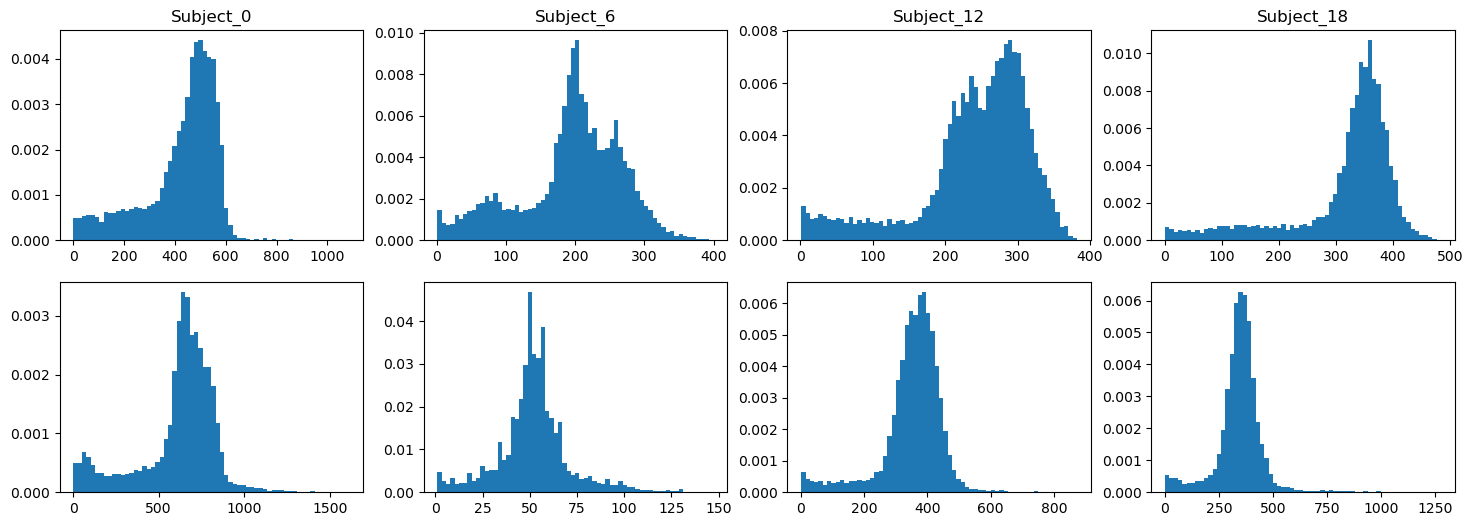

In [5]:

#Datavisaluation 
fig, axs = plt.subplots(2, 4, figsize=(18,6))
for i in range (4):

    path_images_one_subject = glob.glob(path_each_subject[i+3*i] + '/*.nii.gz')
    path_images_one_subject.sort()
    
    flair, seg, t1_ce = load_img(path_images_one_subject, 50)
    
    v_flair = flair.ravel()
    v_t1_ce = t1_ce.ravel()
    
    tiltle = "Subject_"+ str(i+5*i)
    axs[0,i].hist(v_flair[v_flair!=0], bins = 2**6, density = True)
    axs[0,i].set_title(tiltle)
    axs[1,i].hist(v_t1_ce[v_t1_ce!=0], bins = 2**6, density = True)
    
plt.show()




The images is not nomalized between 0 and 1. The normalisation will  be perform by pytorch.

Let's build our dataloarder for the BratsDataset.
For this dataset, we load flair, T1_ce and seg. T1_ce and flair are concatenate to have the follow image shape [240,240,2]. It is more simple to training the U-net. We have chosen to keep the brains of each subject whole to have a solution that can be used in real conditions.

In [6]:
class BratsDataset(Dataset):
    """Brats dataset."""

    def __init__(self, path_brats, z_size,transform=None):
        """
        Args:
            path_brats (string): Path to the Brats2018 dataset
            z_size (int) : number of slice by MRI in z axis
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.z_size = z_size
        self.transform = transform
        self.path_brats = path_brats
        
        
        self.path_sub_intern = glob.glob(path_brats + '/*')
        self.path_sub_intern.sort()

    def __len__(self):
        return len(self.path_sub_intern)*self.z_size

    def __getitem__(self, idx):
        
        file_path = self.path_sub_intern[idx//self.z_size]
        
        img_path = glob.glob(file_path + '/*')
        img_path.sort()
        
        flair, seg, t1_ce = load_img(img_path, idx%self.z_size)
        
        mri_image = flair
        mri_image = np.dstack((mri_image, t1_ce))
        
        
        mri_image_tensor = torch.from_numpy(mri_image.astype(np.float32))
        seg_tensor = torch.from_numpy(seg.astype(np.float32))
        
        mri_image_tensor = torch.moveaxis(mri_image_tensor, -1,0)
        
        return mri_image_tensor, seg_tensor

## Creaction of AI

You have choosen U-Net achitecture to perform the segmentation.  U-Net is CNN architecture able to perform segmentation, especially in biomedical imaging. U-net have been proposed in 2015 by Ronneberger et al. This architecture have many advantage, notably : 
- Efficient trainning, it need small number of images for the trainning
- Flexible, is adapted for many segmenation task (tissu, blood vessel ...)
- Good accuracy

A U-net is composed of two parts :
- Encoder, the purpose of this part is reduce spatial size of the input image. Until a latent space
- Decoder, the purpose of this part is increase spatial size of the latent space. Until a same size of input images.

For loss fonction, we have the choice between MSE and Dice. For this pratical work, we choose Dice function.

Let's build our u-net

In [8]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

In [9]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

In [10]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [11]:
#We define the final achitecture

class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(2, 32)
        self.e2 = encoder_block(32, 64)
        self.e3 = encoder_block(64, 128)
        """ Bottleneck """
        self.b = conv_block(128, 256)
        """ Decoder """
        self.d1 = decoder_block(256, 128)
        self.d2 = decoder_block(128, 64)
        self.d3 = decoder_block(64, 32)
        """ Classifier """
        self.outputs = nn.Conv2d(32, 1, kernel_size=1, padding=0)
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        """ Bottleneck """
        b = self.b(p3)
        """ Decoder """
        d1 = self.d1(b, s3)
        d2 = self.d2(d1, s2)
        d3 = self.d3(d2, s1)
        """ Classifier """
        outputs = self.outputs(d3)
        return outputs

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

unet = build_unet().to(device)


cuda:0


In [46]:
dataset = BratsDataset(z_size = 150, path_brats = path)

training_loader = DataLoader(dataset,batch_size=16, shuffle=True, num_workers=6)
print('Training set has {} instances'.format(len(training_loader)))
dataiter = iter(training_loader)
images, labels = next(dataiter)

Training set has 150 instances


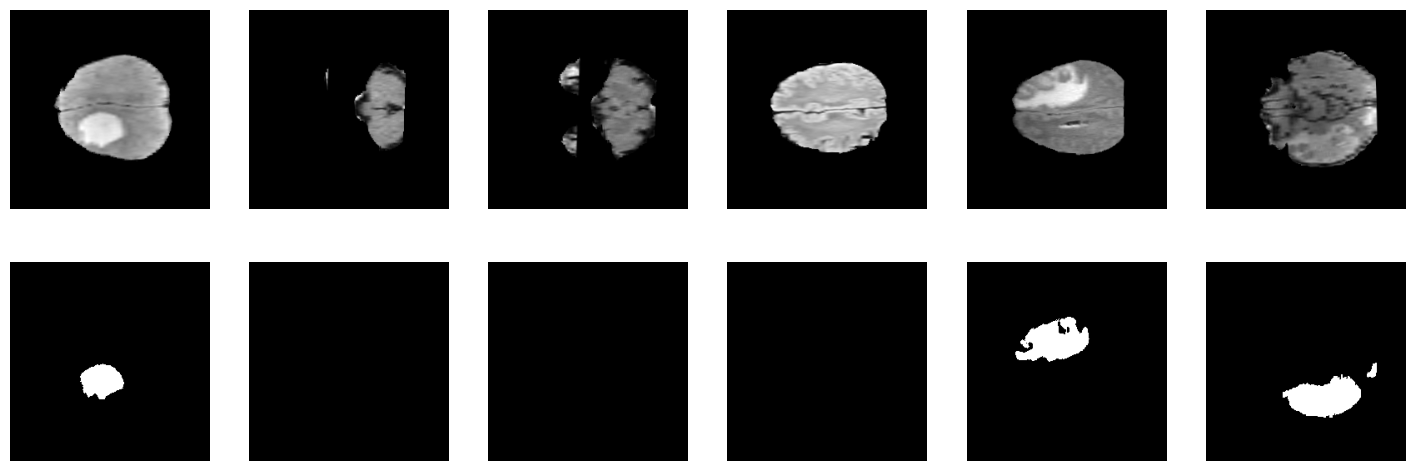

In [60]:
fig, axs = plt.subplots(2, 6, figsize=(18,6))
for i in range(6):
    axs[0,i].imshow(images[i,0,:,:], cmap="gray")
    axs[1,i].imshow(labels[i,0,:,:],cmap="gray")
    axs[0,i].axis('off')
    axs[1,i].axis('off')

In [21]:
#We define the loss function

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
dice = DiceLoss()

In [16]:
#training, around 2 hours in gtx 1060

num_epochs = 25
running_loss = 0.0


for epoch in range(num_epochs):
    running_loss = 0.0
    
    if epoch >= 5 :
        optimizer = torch.optim.Adam(unet.parameters(), lr=0.01)
    if epoch >= 15 :
        optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)
    if epoch >= 22 :
        optimizer = torch.optim.Adam(unet.parameters(), lr=0.0001)
    else :
        optimizer = torch.optim.Adam(unet.parameters(), lr=0.1)
        
    for i, data in enumerate(training_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        output = unet(inputs)
        loss = dice(output, labels)
        print(loss)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    
        # accuracy
        #_, predicted = torch.max(output, y)
        #total_train += y.nelement()
        #correct_train += predicted.eq(y.data).sum().item()
        #train_accuracy = 100 * correct_train / total_train
        #avg_accuracy = train_accuracy / len(train_loader)  
        #,  "Training Accuracy: %d %%" % (train_accuracy)
    
    print("loss for epoch " + str(epoch) + ":  " + str(running_loss))


tensor(0.4953, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6431, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.7513, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6002, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4331, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3700, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3402, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5362, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4214, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2891, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6155, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4912, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4292, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4143, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5361, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3313, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4950, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2115, device='cuda:0',

tensor(0.2999, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3684, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2489, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2383, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2359, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5986, device='cuda:0', grad_fn=<RsubBackward1>)
loss for epoch 0:  57.60834413766861
tensor(0.3178, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2486, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4066, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3726, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4998, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5177, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6403, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5081, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3044, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3333, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3947, device='cuda:0', grad_fn=<RsubBackwa

tensor(0.2193, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2447, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2904, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3378, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2403, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2688, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2883, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3001, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3136, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2908, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3419, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2279, device='cuda:0', grad_fn=<RsubBackward1>)
loss for epoch 1:  49.486413180828094
tensor(0.1721, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2884, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3253, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2272, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4812, device='cuda:0', grad_fn=<RsubBackw

tensor(0.2208, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2827, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4415, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2584, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4924, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3300, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2230, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2401, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2767, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3264, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2372, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3048, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6071, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3723, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2893, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2619, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1970, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1187, device='cuda:0',

tensor(0.1954, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2288, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3094, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2880, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1737, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2196, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2763, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2327, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2307, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2370, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1982, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2656, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2119, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2412, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3161, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1725, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2473, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2159, device='cuda:0',

tensor(0.1969, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2409, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3251, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1505, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2352, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1544, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1549, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2469, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1713, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1610, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1603, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1926, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1640, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2274, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2772, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4435, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.6386, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3429, device='cuda:0',

tensor(0.1965, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1516, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2280, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1761, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2135, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2266, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2997, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1791, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2248, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2557, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2255, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1981, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1879, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1366, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3132, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1802, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2022, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1550, device='cuda:0',

tensor(0.1984, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1219, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1266, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1701, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2379, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2696, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3030, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2176, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1628, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2067, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1959, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1774, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1739, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1530, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2150, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2252, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2055, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2168, device='cuda:0',

tensor(0.2244, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1595, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1576, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1250, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1718, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1730, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1330, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1208, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2183, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2787, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2007, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1219, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1273, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2352, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1231, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1264, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1509, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1528, device='cuda:0',

tensor(0.5524, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1587, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1860, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1540, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1342, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1645, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2984, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2610, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2539, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1493, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2397, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1059, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0960, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2885, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1280, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2771, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1479, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1958, device='cuda:0',

tensor(0.1407, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1138, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2534, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1331, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1715, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2136, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1726, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2413, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3102, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1777, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1114, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1348, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2461, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1230, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3602, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1293, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1404, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1997, device='cuda:0',

tensor(0.2190, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1296, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1237, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1256, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1572, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1934, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1885, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1427, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1250, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1323, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2044, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1700, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1179, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1473, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1186, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2304, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1808, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1766, device='cuda:0',

tensor(0.1030, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1164, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1258, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1230, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1045, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1118, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1621, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0689, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1352, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1028, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2592, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1538, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1407, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1424, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1093, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1571, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1369, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1420, device='cuda:0',

tensor(0.0835, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0935, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0865, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2982, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0963, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1042, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1339, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1277, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1497, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1168, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0980, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0835, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1001, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1660, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0884, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1843, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1134, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1069, device='cuda:0',

tensor(0.2042, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3852, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3814, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2245, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4299, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.5276, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4396, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3992, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2865, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3361, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3154, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3308, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2654, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2762, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.4350, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2308, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2914, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1490, device='cuda:0',

tensor(0.1297, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1221, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1543, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1448, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1775, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1318, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1395, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1278, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1466, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1284, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0858, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1428, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1569, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1059, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1791, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1628, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0805, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1221, device='cuda:0',

tensor(0.1315, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1364, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1212, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1098, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3843, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2116, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1716, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2016, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1433, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1567, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1834, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1341, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1707, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1870, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1727, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1992, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1302, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0957, device='cuda:0',

tensor(0.1037, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0848, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1214, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1406, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0998, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1187, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1109, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0952, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1013, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1242, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1008, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1583, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1964, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1107, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0829, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1098, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1553, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1287, device='cuda:0',

tensor(0.1229, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1599, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1210, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1020, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1543, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2315, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1302, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1529, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1262, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1762, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1248, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1218, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1900, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1062, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1128, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2716, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1104, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1253, device='cuda:0',

tensor(0.0876, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0986, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1216, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1192, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0831, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1528, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1230, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1186, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0893, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1196, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1176, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1143, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1185, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1225, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1222, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1001, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1621, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1312, device='cuda:0',

tensor(0.1044, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1228, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1400, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1538, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1166, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1214, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0674, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1193, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0689, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0899, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0593, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1543, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1026, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0965, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1271, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1178, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0951, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1005, device='cuda:0',

tensor(0.1025, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0930, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1159, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0799, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1169, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1231, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1223, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0738, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0996, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0910, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1176, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1176, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0906, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0646, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0821, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1101, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0866, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0915, device='cuda:0',

tensor(0.1065, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1036, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1251, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1310, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1619, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0896, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.3051, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1349, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1090, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1234, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0788, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1178, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0782, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1143, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0867, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0967, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1406, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1035, device='cuda:0',

tensor(0.1404, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1175, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1105, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0896, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0963, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0913, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0846, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0981, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1980, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1208, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1023, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0827, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1159, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0792, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0826, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1128, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1086, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0809, device='cuda:0',

tensor(0.1051, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0949, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1097, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1053, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0795, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0987, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.2066, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1213, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1217, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1068, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1317, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0941, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0991, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1035, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0798, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0994, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0848, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1183, device='cuda:0',

loss for epoch 23:  15.285005986690521
tensor(0.0877, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1319, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1039, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0899, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0730, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1100, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0830, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0858, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1163, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1148, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0929, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0867, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0775, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1327, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1119, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0922, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1074, device='cuda:0', grad_fn=<RsubBack

tensor(0.0683, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0900, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0868, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.1118, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0656, device='cuda:0', grad_fn=<RsubBackward1>)
tensor(0.0988, device='cuda:0', grad_fn=<RsubBackward1>)
loss for epoch 24:  15.579105913639069


In [48]:
torch.save(unet, 'unet_save.pth')

In [13]:
unet = torch.load("/home/theo/Documents/Biomedical/AI_biomed/unet_save.pth")

## Model evaluation
To evaluate the model, we will make it predict a series of unknown subjects. We will use as a performance criterion the loss function (Dice).

In [15]:
#Loading validation dataset

val_dataset = BratsDataset(z_size = 150, path_brats = '/home/theo/Documents/Biomedical/AI_biomed/brats_test')

val_loader = DataLoader(val_dataset,batch_size=16, shuffle=True, num_workers=6)
print('Training set has {} instances'.format(len(val_loader)))
dataiter = iter(val_loader)

Training set has 422 instances


In [ ]:
#Prediction

unet.eval()
val_loss = []

for i, data in enumerate(val_loader, 0):
    
        val_data, val_labels = data[0].to(device), data[1].to(device)
        with torch.no_grad():
            val_outputs = unet(val_data)
            val_loss.append(dice(val_outputs, val_labels))


average loss :  0.25407383


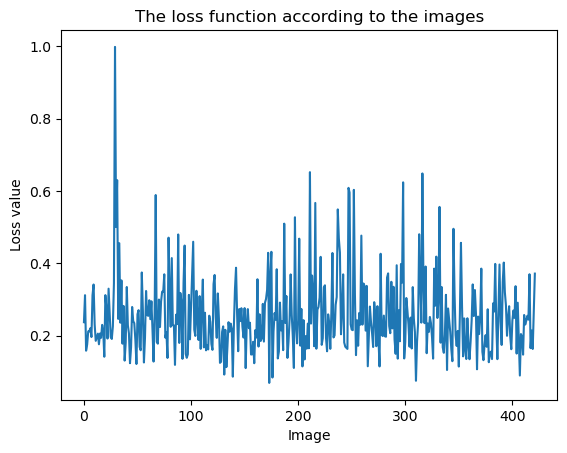

In [45]:
#Data visualization
val_loss_cpu = torch.tensor(val_loss, device = 'cpu')
val_loss_cpu = val_loss_cpu.numpy()

plt.plot(val_loss_cpu)
plt.title("The loss function according to the images")
plt.xlabel("Image")
plt.ylabel("Loss value")
print("average loss : ", np.mean(val_loss_cpu))


As can be seen, the segmentation accuracy is around 25%. This precision is too low considering the application. High accuracy is required. Moreover, we see notable difficulties in the prediction of certain images and an irregularity. Let's look at the prediction made on an image of the validation set.

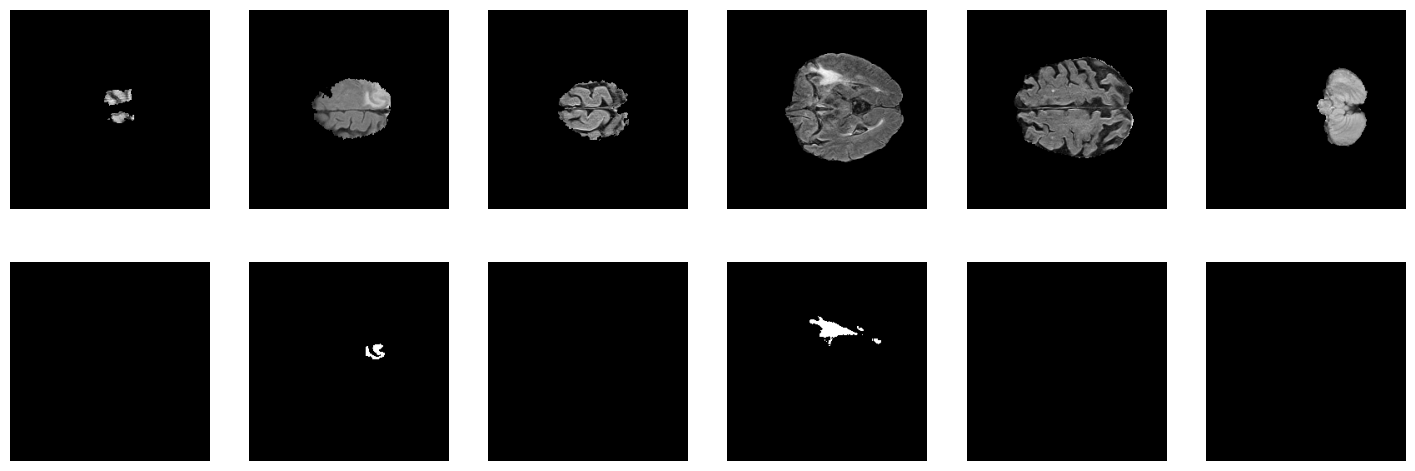

In [24]:
#Loading images

dataiter = iter(val_loader)
images, labels = next(dataiter)
fig, axs = plt.subplots(2, 6, figsize=(18,6))
for i in range(6):
    axs[0,i].imshow(images[i,0,:,:], cmap="gray")
    axs[1,i].imshow(labels[i,0,:,:],cmap="gray")
    axs[0,i].axis('off')
    axs[1,i].axis('off')

In [25]:
#perform prediction

gpu_images, gpu_labels = images.to(device), labels.to(device)
prediction = unet(gpu_images)

torch.Size([16, 2, 240, 240])


/tmp/ipykernel_57035/3784647440.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  prediction_cpu = torch.tensor(prediction, device = 'cpu')


Text(0.5, 1.0, 'Mask real')

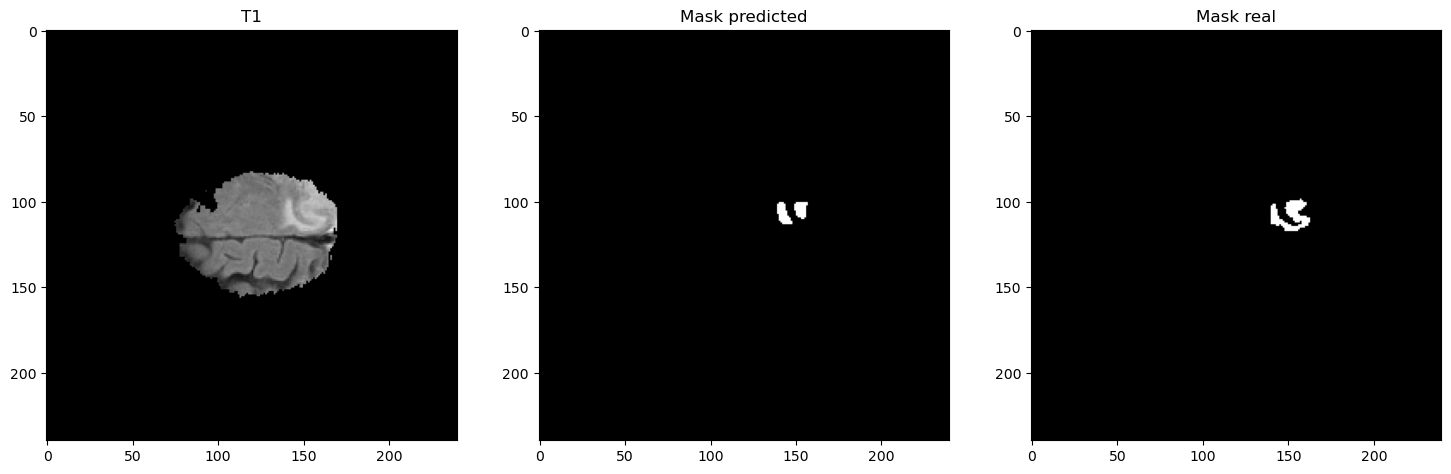

In [42]:
prediction_cpu = torch.tensor(prediction, device = 'cpu')
prediction_cpu_tre = np.where(prediction_cpu<0 ,0,1 )
fig, axs = plt.subplots(1, 3, figsize=(18,6))

axs[0].imshow(images[1,0,:,:], cmap = "gray")
axs[0].set_title("T1")
axs[1].imshow(prediction_cpu_tre[1,0,:,:], cmap = "gray")
axs[1].set_title("Mask predicted")
axs[2].imshow(labels[1,0,:,:], cmap = "gray")
axs[2].set_title("Mask real")

We can conclude that our model is under trained. As shown by the loss curve or the prediction, we have too great a gap between the ground reality and the predictions. In our case, we can imagine several solutions:

- Deploy a pre-trained network and modify it
- Train on a larger part of the database (80%)
- Perform further pre-processing by excluding any images where the brain does not appear.
- Use better architecture like unet-3 ect ...